Number of features: 384
Coalition size distribution: [  1 176  64  40  40  34  30  34  14  23  19  17   9  12  10   8   8  14
  12   6  10   6   6   4   7   3   4   6   6   7   3  10   9  11   3   6
   4   6   1   5   4   4   5   3   4   1   4   4   4   3   2   4   5   2
   4   4   4   2   3   3   2   1   3   3   4   4   1   3   4   2   1   1
   3   4   1   1   1   2   1   4   2   1   3   1   3   1   0   1   1   3
   3   5   2   2   1   5   1   1   2   4   1   3   2   0   2   1   1   1
   2   4   4   5   3   1   1   4   0   1   4   0   0   1   1   1   4   0
   3   1   1   1   1   2   0   3   2   4   2   0   2   0   1   0   6   0
   3   1   6   1   1   2   1   1   1   0   2   4   3   0   0   1   2   0
   2   2   2   2   3   0   3   2   2   0   0   1   1   1   2   4   0   4
   2   0   2   1   0   2   3   1   2   5   2   0   3   1   0   1   0   1
   0   1   1   1   3   0   2   0   2   2   3   2   0   2   0   2   1   2
   2   2   2   3   4   1   1   2   0   3   3   3   2   2   1   4   2   

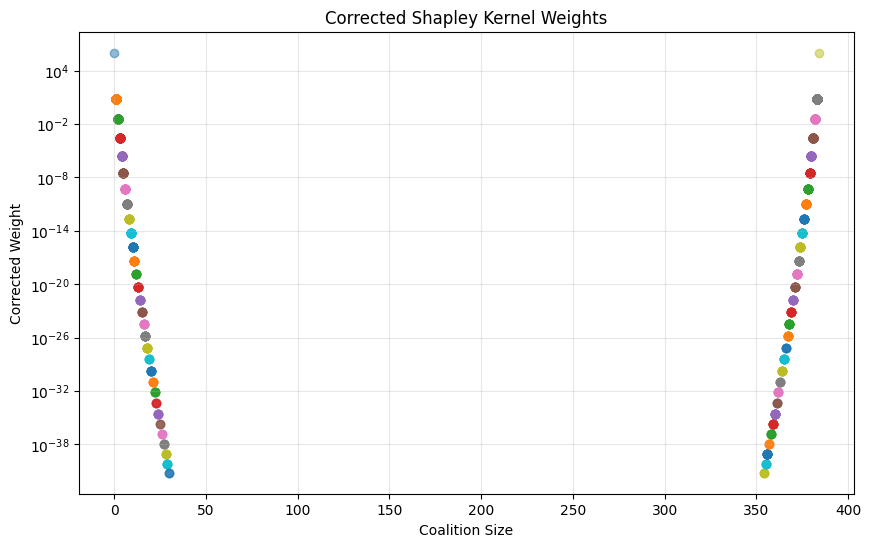

,alpha,0.0003
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,10000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [10]:
import numpy as np
from scipy.special import comb
import torch
from my_load import CPU_Unpickler

with open('dataset-kernel-shap.pkl', 'rb') as f:
    ds = CPU_Unpickler(f).load()

# Extract the tensors
X, y, w_old = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights

# Compute the number of features
M = X.shape[1]

# Compute coalition sizes for each sample
coalition_sizes = X.sum(dim=1).numpy()

# Compute theoretically correct weights
w_corrected = torch.zeros_like(w_old)

for i, k in enumerate(coalition_sizes):
    k = int(k)
    
    if k == 0 or k == M:
        # Keep the large weight for extremes (empty/full coalitions)
        w_corrected[i] = w_old[i]  # This should be inf_weight
    else:
        # Theoretical Shapley kernel weight: π(k) = (M-1) / (k * (M-k) * (M choose k))
        # Sampling probability was: p(k) = (M-1) / (k * (M-k))
        # Importance sampling correction: w = π(k) / p(k) = 1 / (M choose k)
        w_corrected[i] = 1.0 / comb(M, k, exact=False)

# Normalize weights to have reasonable scale while preserving ratios
# (optional, but helps with numerical stability)
non_extreme_mask = (coalition_sizes > 0) & (coalition_sizes < M)
if non_extreme_mask.any():
    mean_non_extreme = w_corrected[non_extreme_mask].mean()
    w_corrected[non_extreme_mask] /= mean_non_extreme

print(f"Number of features: {M}")
print(f"Coalition size distribution: {np.bincount(coalition_sizes.astype(int))}")
print(f"Original weights - min: {w_old.min():.2e}, max: {w_old.max():.2e}")
print(f"Corrected weights - min: {w_corrected.min():.2e}, max: {w_corrected.max():.2e}")

# Visualize the weight distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for k in range(M+1):
    mask = coalition_sizes == k
    if mask.any():
        plt.scatter([k]*mask.sum(), w_corrected[mask], alpha=0.5, label=f'k={k}')

plt.xlabel('Coalition Size')
plt.ylabel('Corrected Weight')
plt.yscale('log')
plt.title('Corrected Shapley Kernel Weights')
plt.grid(True, alpha=0.3)
plt.show()

# Now you can use these corrected weights with your surrogate model
# For example, with sklearn:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# Convert to numpy for sklearn
X_np = X.numpy()
y_np = y.numpy()
w_np = w_corrected.numpy()

# Fit with corrected weights
model = Lasso(alpha=0.0003, max_iter=10000)#LinearRegression()
model.fit(X_np, y_np, sample_weight=w_np)
model_without_correction = Lasso(alpha=0.0003, max_iter=10000)#LinearRegression()
model_without_correction.fit(X_np, y_np, sample_weight=w_old.numpy())

# Or with Lasso/Ridge
# model = Lasso(alpha=0.01)
# model = Ridge(alpha=0.01)
# model.fit(X_np, y_np, sample_weight=w_np)

In [11]:
# Check if the model satisfies efficiency constraint
intercept = model.intercept_
coefficients = model.coef_
print(f"Sum of coefficients: {coefficients.sum():.6f}")
print(f"Should equal (f(x) - f(∅)): {(y[coalition_sizes == M][0] - y[coalition_sizes == 0][0]).item():.6f}")

Sum of coefficients: 0.006014
Should equal (f(x) - f(∅)): 0.007214


In [12]:
# do the same for the model without correction
intercept_without_correction = model_without_correction.intercept_
coefficients_without_correction = model_without_correction.coef_
print(f"Sum of coefficients without correction: {coefficients_without_correction.sum():.6f}")
print(f"Should equal (f(x) - f(∅)): {(y[coalition_sizes == M][0] - y[coalition_sizes == 0][0]).item():.6f}")

Sum of coefficients without correction: 0.006014
Should equal (f(x) - f(∅)): 0.007214


In [13]:
print(coefficients)
print(coefficients_without_correction)

[6.0137608e-03 1.6164780e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000